# IBM Applied Data Science Capstone Project - Fabrizio Ruffini

# Intro
After the **COVID-19 outbreak**, the working habits will likely change from an office-centered perspective to a more **home-based** culture with a prevalence of **smart-working approach**. Thus, moving to cities where the life quality is higher, and in particular to green neighborhoods will possibly become important, also to provide your family with a **sane** and **safe** environment where to live.

In this analysis we are going to compare the **four main Italian cities** in terms of **pollution** with a focus on "**air quality**, and once we chose the "most interesting one" we will look for an **appealing neighborhood in terms of life quality**, looking at the availability of green areas (parks, gardens...), small shops and also their crowded-levels.


### Step 0. Setupping

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline

In [2]:
# Matplotlib and associated plotting modules
import matplotlib.cm as cm
import matplotlib.colors as colors

# import k-means from clustering stage
from sklearn.cluster import KMeans

#!conda install -c conda-forge folium=0.5.0 --yes 
import folium # map rendering library

import requests # library to handle requests

Intel(R) Data Analytics Acceleration Library (Intel(R) DAAL) solvers for sklearn enabled: https://intelpython.github.io/daal4py/sklearn.html


In [3]:
print("Hello Capstone Project Course!")

Hello Capstone Project Course!


### Step 1. DAQ (Data AcQuisition)

#### Data sources description
##### Pollution data
Pollution data are taken from Copernicus Atmosphere dataset. As a representative dataset, we took the whole 2019 year, and we also added the most recent data available at the time of the analysis (up to June 2020).

The pollutant variables chosen are **NO2**, **O3**, **PM2.5**, **PM10**. Note that there are also additional pollutants, such as SO2, CO, NO, toluene, benzene and many harmful others. They are not treated here.

+ **NO2**: nitrogen dioxide level measured in μg/m³.   
Source: In cities comes from motor vehicle exhaust (about 80%),petrol, metal refining, electricity generation from coal-fired power stations.  
Effect: Long-term exposure is a cause of chronic lung diseases, and are harmful for the vegetation. Nitrogen Dioxide is gaseous air pollutants which is released mainly during fuel combustion from the reaction of nitrogen and oxygen gases. Coughing, wheezing or difficulty breathing  
More about NO2 and its effects can be found here https://www.epa.gov/no2-pollution/basic-information-about-no2 

+ **O3**: Ground-level Ozone measured in μg/m³. Ozone is a gas that is formed when nitrogen oxides react with a group of air pollutants known as ‘reactive organic substances’ in the presence of sunlight.  
Source: Emitted by cars, power plants, industrial boilers, refineries, chemical plants.  
Effect: High levels can produce asthma, bronchytis or other chronic pulmonary diseases in sensitive groups or outdoor workers. Also, chest pain, coughing, throat irritation, and airway inflammation.  
More about O3 and its effects can be found here https://www.epa.gov/ground-level-ozone-pollution/ground-level-ozone-basics

+ **PM2.5**: Besides gaseous pollutants, the atmosphere can also be polluted by particles. These particles have a divergent composition and size and are sometimes called aerosols. They are often catalogued as ‘floating dust’, but are best known as particulate matter (PM). PM2.5 are particles smaller than 2.5 μm level measured in μg/m³. The size of these particles allow them to penetrate into the gas exchange regions of the lungs (alveolus) and even enter the arteries.  
Source: Formed from construction sites, unpaved roads, fields, smokestacks or fires.  
Effect: Irregular heartbeat,aggravated asthma,decreased lung function.  Long-term exposure is proven to be related to low birth weight and high blood pressure in newborn babies.  
More about PM and its effect here https://www.epa.gov/pm-pollution/particulate-matter-pm-basics


+ **PM10**: particles smaller than 10 μm. Even though the cannot penetrate the alveolus, they can still penetrate through the lungs and affect other organs. 
Source: Formed from construction sites, unpaved roads, fields, smokestacks or fires.  
Effect: Irregular heartbeat,aggravated asthma,decreased lung function. Long term exposure can result in lung cancer and cardiovascular complications.  
More about PM and its effect here https://www.epa.gov/pm-pollution/particulate-matter-pm-basics


Using pollutant variables it is possible to evaluate an index called **air quality index (AQI)** used by government agencies to communicate to the public how polluted the air and to easy understand the correlated risks. Over the time, there has been different air quality indeces. In the following, we will use the definition based on this document from EPA (Environmental Protection Agency of United States).
https://www.epa.gov/sites/production/files/2014-05/documents/zell-aqi.pdf

AQI It converts the measured pollutant concentrations in a communities air to a number on a scale of 0 to 500 and above.

##### Neighborhood life quality data
Neighborhood life quality data are taken from google and Foursquare APIs.

In [4]:
import os, ssl
if (not os.environ.get('PYTHONHTTPSVERIFY', '') and getattr(ssl, '_create_unverified_context', None)):
    ssl._create_default_https_context = ssl._create_unverified_context

url_loc = "https://raw.githubusercontent.com/CopernicusAtmosphere/air-quality-covid19-response/master/CAMS_AQ_LOCATIONS_V1.csv"
df_raw_loc = pd.read_csv(url_loc)
df_raw_loc.head()
df_raw_ita = df_raw_loc[df_raw_loc["country"]== "Italy"]
df_raw_ita = df_raw_ita.rename(columns={"id":"city_id"})
df_raw_ita

,city_id,country,name,country_code,latitude,longitude
24,AQ025,Italy,Milan,IT,45.47,9.18
27,AQ028,Italy,Naples,IT,40.86,14.25
36,AQ037,Italy,Rome,IT,41.90,12.48
43,AQ044,Italy,Turin,IT,45.12,7.74


In [5]:
# making a map of the Italian 4 cities
map_4cities = folium.Map(location=[40.86, 14.25], zoom_start=6)  

from folium.features import DivIcon

for _, row in df_raw_ita.iterrows():
    folium.CircleMarker(location=[row["latitude"], row["longitude"]], 
                                radius=6,).add_to(map_4cities)

    folium.Marker(location=[row["latitude"], row["longitude"]], icon=DivIcon(icon_size=(150,36), icon_anchor=(0,0),
        html='<div style="font-size: 12pt;">{}</div>'.format(row['name']))).add_to(map_4cities)


map_4cities

In [6]:
url_2019 = "https://raw.githubusercontent.com/CopernicusAtmosphere/air-quality-covid19-response/master/cams_air_quality_analysis_2019.csv"
df_raw_2019 = pd.read_csv(url_2019) #,index_col=0)
df_raw_2019.head(3)

,basetime,city_id,NO2,O3,PM10,PM2.5
0,2019-01-01,AQ001,11.44,58.45,16.48,8.32
1,2019-01-01,AQ002,31.17,43.61,25.82,23.21
2,2019-01-01,AQ003,13.54,59.26,5.77,4.11


In [7]:
url_2020 = "https://raw.githubusercontent.com/CopernicusAtmosphere/air-quality-covid19-response/master/cams_air_quality_analysis_2020.csv"
df_raw_2020 = pd.read_csv(url_2020) #,index_col=0)
df_raw_2020.head(3)

,basetime,city_id,NO2,O3,PM10,PM2.5
0,2020-01-01,AQ001,34.81,9.18,33.83,29.49
1,2020-01-01,AQ002,18.88,29.20,22.01,18.55
2,2020-01-01,AQ003,19.87,50.75,11.83,8.80


In [8]:
df_raw_1920 = pd.concat([df_raw_2019, df_raw_2020])
df_raw_1920.head(2)

,basetime,city_id,NO2,O3,PM10,PM2.5
0,2019-01-01,AQ001,11.44,58.45,16.48,8.32
1,2019-01-01,AQ002,31.17,43.61,25.82,23.21


In [9]:
df_raw_airq = pd.merge(df_raw_1920, df_raw_ita, on=['city_id'])
df_raw_airq.head(3)

,basetime,city_id,NO2,O3,PM10,PM2.5,country,name,country_code,latitude,longitude
0,2019-01-01,AQ025,48.76,5.03,41.18,35.12,Italy,Milan,IT,45.47,9.18
1,2019-01-02,AQ025,16.50,55.70,6.00,5.17,Italy,Milan,IT,45.47,9.18
2,2019-01-03,AQ025,34.28,26.97,14.19,11.44,Italy,Milan,IT,45.47,9.18


In [10]:
# creating 4 dataframes (one for each city) for convenience
df_Milan_airq = df_raw_airq[df_raw_airq["name"]=="Milan"]
df_Rome_airq = df_raw_airq[df_raw_airq["name"]=="Rome"]
df_Turin_airq = df_raw_airq[df_raw_airq["name"]=="Turin"]
df_Naples_airq = df_raw_airq[df_raw_airq["name"]=="Naples"]

In [11]:
df_raw_airq= df_raw_airq.set_index(["basetime", "name"])
df_raw_airq.head(2)

,,city_id,NO2,O3,PM10,PM2.5,country,country_code,latitude,longitude
basetime,name,,,,,,,,,
2019-01-01,Milan,AQ025,48.76,5.03,41.18,35.12,Italy,IT,45.47,9.18
2019-01-02,Milan,AQ025,16.50,55.70,6.00,5.17,Italy,IT,45.47,9.18


In [12]:
df_raw_airq.tail(2)

,,city_id,NO2,O3,PM10,PM2.5,country,country_code,latitude,longitude
basetime,name,,,,,,,,,
2020-06-03,Turin,AQ044,10.80,73.38,11.75,10.70,Italy,IT,45.12,7.74
2020-06-04,Turin,AQ044,12.09,55.80,8.11,7.17,Italy,IT,45.12,7.74


In [13]:
df_raw_airq.describe()

,NO2,O3,PM10,PM2.5,latitude,longitude
count,2084.000000,2084.000000,2084.000000,2084.000000,2084.000000,2084.000000
mean,25.567572,51.201512,22.343796,17.406036,43.337500,10.912500
std,13.532913,23.359638,12.392710,10.717463,1.996054,2.582396
min,4.460000,0.960000,3.620000,2.980000,40.860000,7.740000
25%,15.150000,35.730000,13.985000,10.132500,41.640000,8.820000
50%,22.140000,54.200000,19.645000,14.705000,43.510000,10.830000
75%,32.757500,69.040000,26.700000,21.107500,45.207500,12.922500
max,78.280000,129.070000,78.940000,70.270000,45.470000,14.250000


In [14]:
# saving file for further reference
df_raw_airq.to_csv("./Data/df_raw_airq_01012019_03062020.csv")

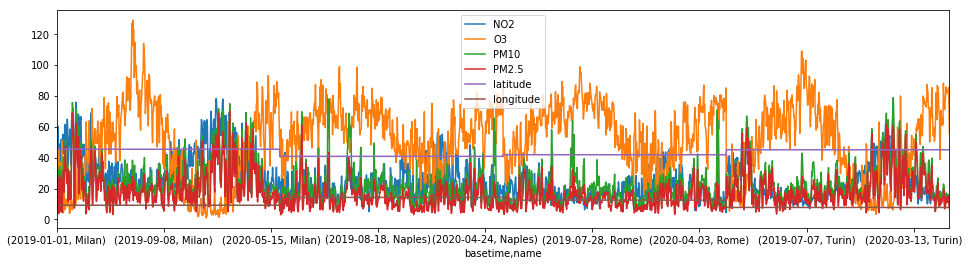

In [15]:
df_raw_airq.plot(figsize=(16,4))

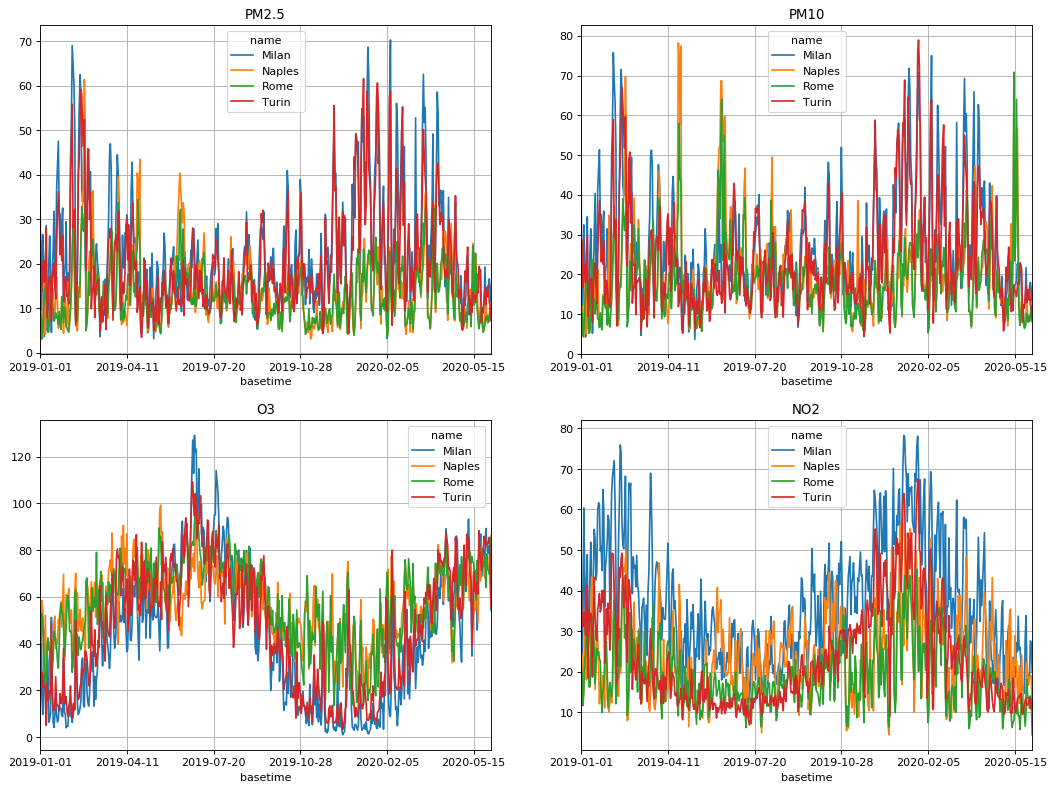

In [16]:
#df_raw_airq.plot(figsize=(16, 9), title='Population');
f, a = plt.subplots(nrows=2, ncols=2, figsize=(16, 12), dpi= 80)
df_raw_airq.reset_index().pivot('basetime','name','NO2').plot(ax=a[1,1],  title='NO2', grid=True)
df_raw_airq.reset_index().pivot('basetime','name','O3').plot(ax=a[1,0],   title='O3', grid=True)
df_raw_airq.reset_index().pivot('basetime','name','PM10').plot(ax=a[0,1], title='PM10', grid=True)
df_raw_airq.reset_index().pivot('basetime','name','PM2.5').plot(ax=a[0,0],title='PM2.5', grid=True)

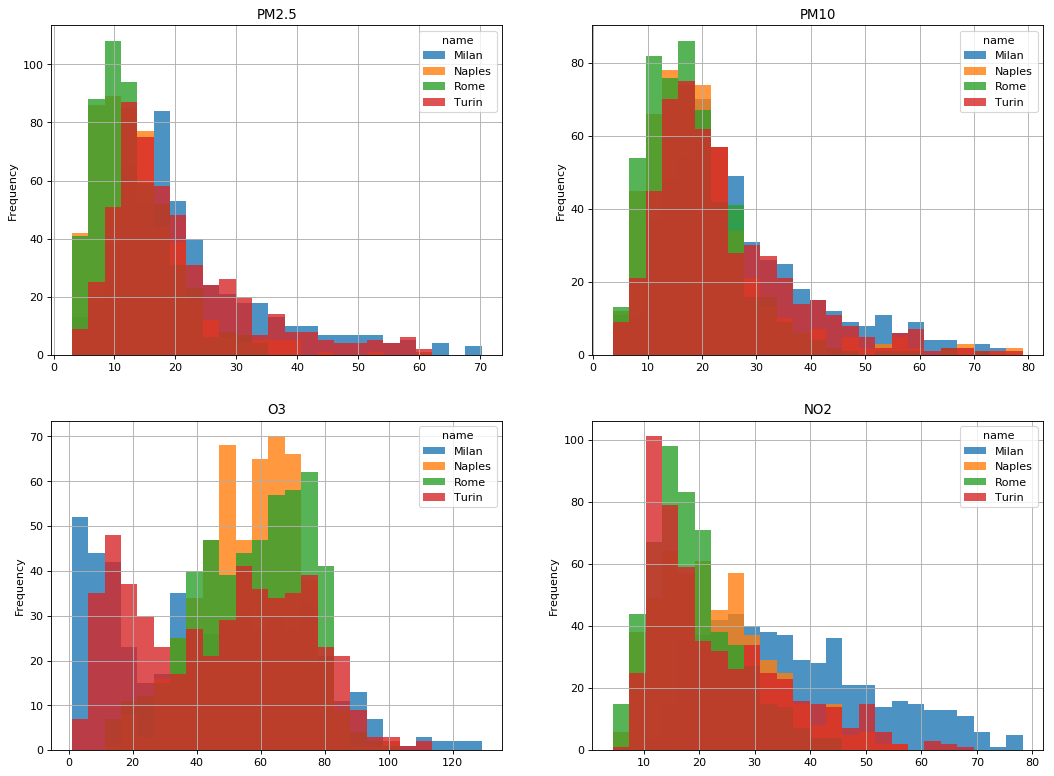

In [17]:
#df_raw_airq.plot(figsize=(16, 9), title='Population');
f, a = plt.subplots(nrows=2, ncols=2, figsize=(16, 12), dpi= 80)
df_raw_airq.reset_index().pivot('basetime','name','NO2').plot.hist(ax=a[1,1],  title="NO2",  grid=True, bins=25, alpha = 0.8)
df_raw_airq.reset_index().pivot('basetime','name','O3').plot.hist(ax=a[1,0],   title="O3",   grid=True, bins=25, alpha = 0.8)
df_raw_airq.reset_index().pivot('basetime','name','PM10').plot.hist(ax=a[0,1], title="PM10", grid=True, bins=25, alpha = 0.8)
df_raw_airq.reset_index().pivot('basetime','name','PM2.5').plot.hist(ax=a[0,0],title="PM2.5",grid=True, bins=25, alpha = 0.8)

In [18]:
df_raw_airq.describe()

,NO2,O3,PM10,PM2.5,latitude,longitude
count,2084.000000,2084.000000,2084.000000,2084.000000,2084.000000,2084.000000
mean,25.567572,51.201512,22.343796,17.406036,43.337500,10.912500
std,13.532913,23.359638,12.392710,10.717463,1.996054,2.582396
min,4.460000,0.960000,3.620000,2.980000,40.860000,7.740000
25%,15.150000,35.730000,13.985000,10.132500,41.640000,8.820000
50%,22.140000,54.200000,19.645000,14.705000,43.510000,10.830000
75%,32.757500,69.040000,26.700000,21.107500,45.207500,12.922500
max,78.280000,129.070000,78.940000,70.270000,45.470000,14.250000


### Step 2. Data exploration
we will look at the differences between cities to create a ranking

In [19]:
city_comp = {'Milan': [df_Milan_airq["PM2.5"].median(),
                       df_Milan_airq["PM10"].median(),
                       df_Milan_airq["NO2"].median(),
                       df_Milan_airq["O3"].median()],
             'Rome': [df_Rome_airq["PM2.5"].median(),
                       df_Rome_airq["PM10"].median(),
                       df_Rome_airq["NO2"].median(),
                       df_Rome_airq["O3"].median()],
            'Turin': [df_Turin_airq["PM2.5"].median(),
                       df_Turin_airq["PM10"].median(),
                       df_Turin_airq["NO2"].median(),
                       df_Turin_airq["O3"].median()],
            'Naples': [df_Naples_airq["PM2.5"].median(),
                       df_Naples_airq["PM10"].median(),
                       df_Naples_airq["NO2"].median(),
                       df_Naples_airq["O3"].median()],
            }

df_city_comp_raw = pd.DataFrame(city_comp)
df_city_comp = df_city_comp_raw.T
df_city_comp.columns = ['PM2.5', 'PM10', 'NO2', 'O3']

minValueIndexObj = df_city_comp.idxmin(axis=0)
 
print("Min values of row are at following columns :")
print(minValueIndexObj)
df_city_comp

Min values of row are at following columns :
PM2.5     Rome
PM10      Rome
NO2       Rome
O3       Milan
dtype: object


,PM2.5,PM10,NO2,O3
Milan,18.95,22.99,34.46,42.35
Rome,11.59,17.08,17.42,59.87
Turin,16.99,20.74,19.09,49.85
Naples,12.29,17.91,21.65,58.23


In [20]:
city_var_comp = {'Milan': [df_Milan_airq["PM2.5"].std(),
                       df_Milan_airq["PM10"].std(),
                       df_Milan_airq["NO2"].std(),
                       df_Milan_airq["O3"].std()],
             'Rome': [df_Rome_airq["PM2.5"].std(),
                       df_Rome_airq["PM10"].std(),
                       df_Rome_airq["NO2"].std(),
                       df_Rome_airq["O3"].std()],
            'Turin': [df_Turin_airq["PM2.5"].std(),
                       df_Turin_airq["PM10"].std(),
                       df_Turin_airq["NO2"].std(),
                       df_Turin_airq["O3"].std()],
            'Naples': [df_Naples_airq["PM2.5"].std(),
                       df_Naples_airq["PM10"].std(),
                       df_Naples_airq["NO2"].std(),
                       df_Naples_airq["O3"].std()],
            }

df_city_var_comp_raw = pd.DataFrame(city_var_comp)
df_city_var_comp = df_city_var_comp_raw.T
df_city_var_comp.columns = ['PM2.5', 'PM10', 'NO2', 'O3']

minValueIndexObj_var = df_city_var_comp.idxmin(axis=0)
 
print("Min values of row are at following columns :")
print(minValueIndexObj_var)
df_city_var_comp

Min values of row are at following columns :
PM2.5      Rome
PM10       Rome
NO2        Rome
O3       Naples
dtype: object


,PM2.5,PM10,NO2,O3
Milan,12.799625,14.055047,15.056034,28.898404
Rome,6.135920,9.054817,7.840341,17.678895
Turin,11.480605,12.770800,12.417726,25.829008
Naples,7.629510,11.409465,10.243778,14.971924


##### From the comparison...
...we can observe that except for Ozone value, 
for all the other parameters Rome has the minimum value of median pullution.  
To provide more user-friendly information, we will also calculate the air quality index.

### Step 3. Data preprocessing
Since the data are daily-based, we cannot calculate the air quality indeces for all of them (in particular, we would only look at PM2.5 and PM10).

#### Comparing air quality indeces
To evaluate and compare the quality indeces of the different cities, we will need to calculate the AQI. Since the pollutant parameters are different and have different effects n the health as well, the functional formula is the same, but the internal parameters changes. We will take advantage of the python aqi package https://pypi.org/project/python-aqi/

In [21]:
import aqi   #package to calculate aqi from https://pypi.org/project/python-aqi/
print("", aqi.POLLUTANT_PM25, '31')
myaqi = aqi.to_aqi([ (aqi.POLLUTANT_PM25, '31'),])
print("myaqi", myaqi)
#myaqi = aqi.to_aqi([
#    (aqi.POLLUTANT_PM25, '12'),
#    (aqi.POLLUTANT_PM10, '24'),
#    (aqi.POLLUTANT_NO2_1H, '0.087'),
#    (aqi.POLLUTANT_O3_8H, '0.01')
#])

def convert_aqi_PM25(obs):
    result = aqi.to_aqi([ (aqi.POLLUTANT_PM25, '{}'.format(obs)),]) 
    return float(result)

def convert_aqi_PM10(obs):
    result = aqi.to_aqi([ (aqi.POLLUTANT_PM10, '{}'.format(obs)),]) 
    return float(result)

 pm25 31
myaqi 91


In [22]:
df_raw_airq["aqi_pm25"] = df_raw_airq["PM2.5"].apply( convert_aqi_PM25 )
df_raw_airq["aqi_pm10"] = df_raw_airq["PM10"].apply( convert_aqi_PM25 )

df_raw_airq


,,city_id,NO2,O3,PM10,PM2.5,country,country_code,latitude,longitude,aqi_pm25,aqi_pm10
basetime,name,,,,,,,,,,,
2019-01-01,Milan,AQ025,48.76,5.03,41.18,35.12,Italy,IT,45.47,9.18,99.0,115.0
2019-01-02,Milan,AQ025,16.50,55.70,6.00,5.17,Italy,IT,45.47,9.18,21.0,25.0
2019-01-03,Milan,AQ025,34.28,26.97,14.19,11.44,Italy,IT,45.47,9.18,48.0,55.0
2019-01-04,Milan,AQ025,60.38,9.66,32.43,26.55,Italy,IT,45.47,9.18,81.0,94.0
2019-01-05,Milan,AQ025,43.51,23.12,24.26,21.39,Italy,IT,45.47,9.18,70.0,76.0
...,...,...,...,...,...,...,...,...,...,...,...,...
2020-05-31,Turin,AQ044,12.27,82.69,13.56,12.67,Italy,IT,45.12,7.74,52.0,54.0
2020-06-01,Turin,AQ044,13.68,83.17,16.28,15.20,Italy,IT,45.12,7.74,58.0,60.0
2020-06-02,Turin,AQ044,13.27,85.41,12.35,11.23,Italy,IT,45.12,7.74,47.0,51.0


In [23]:
df_Rome_airq["aqi_pm25"] = df_Rome_airq["PM2.5"].apply( convert_aqi_PM25 )
df_Rome_airq["aqi_pm10"] = df_Rome_airq["PM10"].apply( convert_aqi_PM25 )

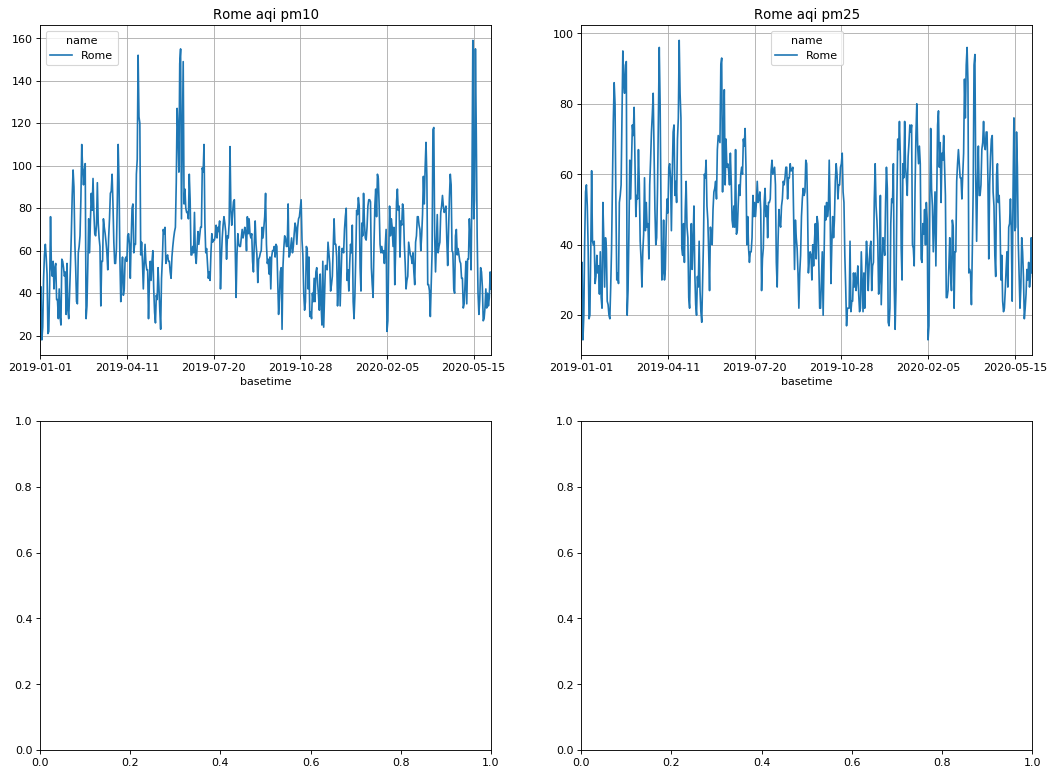

In [24]:
f, a = plt.subplots(nrows=2, ncols=2, figsize=(16, 12), dpi= 80)
df_Rome_airq.reset_index().pivot('basetime','name','aqi_pm25').plot(ax=a[0,1],  title='Rome aqi pm25', grid=True)
df_Rome_airq.reset_index().pivot('basetime','name','aqi_pm10').plot(ax=a[0,0],  title='Rome aqi pm10', grid=True)

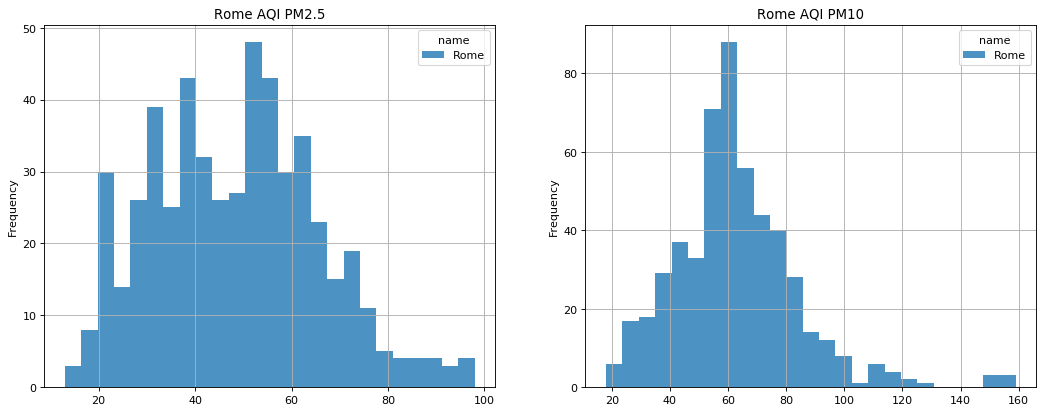

In [25]:
#df_raw_airq.plot(figsize=(16, 9), title='Population');
f, a = plt.subplots(nrows=1, ncols=2, figsize=(16, 6), dpi= 80)
df_Rome_airq.reset_index().pivot('basetime','name','aqi_pm25').plot.hist(ax=a[0], title="Rome AQI PM2.5", grid=True, bins=25, alpha = 0.8)
df_Rome_airq.reset_index().pivot('basetime','name','aqi_pm10').plot.hist(ax=a[1],title="Rome AQI PM10",grid=True, bins=25, alpha = 0.8)

In [26]:
df_Rome_airq.describe()

,NO2,O3,PM10,PM2.5,latitude,longitude,aqi_pm25,aqi_pm10
count,521.000000,521.000000,521.000000,521.000000,5.210000e+02,5.210000e+02,521.000000,521.000000
mean,18.872399,57.363896,18.405106,12.933301,4.190000e+01,1.248000e+01,48.272553,62.606526
std,7.840341,17.678895,9.054817,6.135920,1.706941e-13,1.511354e-13,17.333011,21.237138
min,4.490000,13.390000,4.460000,3.210000,4.190000e+01,1.248000e+01,13.000000,18.000000
25%,13.400000,44.400000,12.050000,8.420000,4.190000e+01,1.248000e+01,35.000000,50.000000
50%,17.420000,59.870000,17.080000,11.590000,4.190000e+01,1.248000e+01,48.000000,61.000000
75%,23.360000,71.410000,22.420000,16.500000,4.190000e+01,1.248000e+01,60.000000,73.000000
max,45.200000,98.890000,70.840000,34.440000,4.190000e+01,1.248000e+01,98.000000,159.000000


#### in conclusion...,

...if you want to move in one of these cities, our proposal would be to move to **Rome**

Let's now see which Rome neighboor you should move to

### Data Visualization

create a map of Rome using folium

In [27]:
# create map of Rome using latitude and longitude values
lat_Rome = 41.891076
lon_Rome = 12.504403
map_RO = folium.Map(location=[lat_Rome, lon_Rome], zoom_start=10)    
map_RO

In [28]:
# create a map of Rome neightboors
df_geo = pd.read_csv("./Data/Rome_municipalities.csv", sep=";")
df_geo

,Municipio,lat,lon
0,municipio 1,41.893056,12.482778
1,municipio 2,41.929958,12.518931
2,municipio 3,41.936080,12.535116
3,municipio 4,41.933491,12.598746
4,municipio 5,41.890665,12.548488
5,municipio 6,41.869657,12.632731
6,municipio 7,41.881700,12.522800
7,municipio 8,41.841228,12.484290
8,municipio 9,41.814879,12.479980
9,municipio 10,41.730660,12.280531


In [29]:
df_geoneighborhoods = df_geo.copy()

# add markers to map
for lat, lng, neighborhood in zip(df_geoneighborhoods['lat'], df_geoneighborhoods['lon'], df_geoneighborhoods['Municipio']):
    label = '{}'.format(neighborhood)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_RO)  

map_RO

In [30]:
# XXX  TO BE removed
CLIENT_ID = "your Foursquare ID"
CLIENT_SECRET = "your Foursquare Secret"
VERSION = '20180605' # Foursquare API version

In [31]:
#### Now, let's get the top 2 venues that are within a radius of 1000 meters of Rome Center.

radius = 1000
LIMIT = 100
url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
    CLIENT_ID, 
    CLIENT_SECRET, 
    VERSION, 
    lat_Rome,
    lon_Rome,
    radius, 
    LIMIT)
results = requests.get(url).json()
results

{'meta': {'code': 200, 'requestId': '5eda3ff7660a9f001b4905c2'},
 'response': {'groups': [{'items': [{'reasons': {'count': 0,
       'items': [{'reasonName': 'globalInteractionReason',
         'summary': 'This spot is popular',
         'type': 'general'}]},
      'referralId': 'e-0-5ad73170ff03066946829905-0',
      'venue': {'categories': [{'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/arts_entertainment/museum_art_',
          'suffix': '.png'},
         'id': '4bf58dd8d48988d18f941735',
         'name': 'Art Museum',
         'pluralName': 'Art Museums',
         'primary': True,
         'shortName': 'Art Museum'}],
       'id': '5ad73170ff03066946829905',
       'location': {'address': 'Via Merulana, 121',
        'cc': 'IT',
        'city': 'Roma',
        'country': 'Italia',
        'distance': 161,
        'formattedAddress': ['Via Merulana, 121',
         '00185 Roma Lazio',
         'Italia'],
        'labeledLatLngs': [{'label': 'display',
          'lat': 41

In [32]:
# function that extracts the category of the venue
def get_category_type(row):
    try:
        categories_list = row['categories']
    except:
        categories_list = row['venue.categories']
        
    if len(categories_list) == 0:
        return None
    else:
        return categories_list[0]['name']

In [33]:
from pandas.io.json import json_normalize # tranform JSON file into a pandas dataframe

venues = results['response']['groups'][0]['items']
    
nearby_venues = json_normalize(venues) # flatten JSON

# filter columns
filtered_columns = ['venue.name', 'venue.categories', 'venue.location.lat', 'venue.location.lng']
nearby_venues =nearby_venues.loc[:, filtered_columns]

# filter the category for each row
nearby_venues['venue.categories'] = nearby_venues.apply(get_category_type, axis=1)

# clean columns
nearby_venues.columns = [col.split(".")[-1] for col in nearby_venues.columns]

nearby_venues.head()

,name,categories,lat,lng
0,Palazzo Merulana,Art Museum,41.889889,12.503289
1,RADICI - Pizzicheria Salentina,Deli / Bodega,41.892456,12.505773
2,Bar Trani,Café,41.893034,12.505343
3,civico 31,Bed & Breakfast,41.892445,12.505911
4,Gatsby Café,Lounge,41.893912,12.504043


In [34]:
## 2. Explore Neighborhoods in Rome
#### Let's create a function to repeat the same process to all the neighborhoods in Rome

In [35]:
def getNearbyVenues(names, latitudes, longitudes, radius=500):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        print(name)
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighborhood', 
                  'Neighborhood Latitude', 
                  'Neighborhood Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)


Rome_venues = getNearbyVenues(names=df_geoneighborhoods['Municipio'],
                                   latitudes=df_geoneighborhoods['lat'],
                                   longitudes=df_geoneighborhoods['lon']
                                  )
Rome_venues.head()

municipio 1
municipio 2
municipio 3
municipio 4
municipio 5
municipio 6
municipio 7
municipio 8
municipio 9
municipio 10
municipio 11
municipio 12
municipio 13
municipio 14
municipio 15


,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,municipio 1,41.893056,12.482778,Piazza del Campidoglio,41.893321,12.482956,Plaza
1,municipio 1,41.893056,12.482778,Terrazza delle Quadrighe,41.894346,12.483336,Scenic Lookout
2,municipio 1,41.893056,12.482778,Foro di Cesare,41.894128,12.485232,Historic Site
3,municipio 1,41.893056,12.482778,Teatro Della Cometa,41.893399,12.481593,Theater
4,municipio 1,41.893056,12.482778,Capitoline Hill (Campidoglio),41.893462,12.483588,Scenic Lookout


In [36]:
#Analyse each neigh

# one hot encoding
Rome_onehot = pd.get_dummies(Rome_venues[['Venue Category']], prefix="", prefix_sep="")

# add neighborhood column back to dataframe
Rome_onehot['Neighborhood'] = Rome_venues['Neighborhood'] 

# move neighborhood column to the first column
fixed_columns = [Rome_onehot.columns[-1]] + list(Rome_onehot.columns[:-1])
Rome_onehot = Rome_onehot[fixed_columns]

Rome_onehot.head()

,Neighborhood,African Restaurant,American Restaurant,Art Gallery,Art Museum,Asian Restaurant,Bakery,Bar,Basketball Court,Beach,...,Supermarket,Temple,Thai Restaurant,Theater,Tourist Information Center,Trattoria/Osteria,Turkish Restaurant,Vegetarian / Vegan Restaurant,Wine Bar,Women's Store
0,municipio 1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,municipio 1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,municipio 1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,municipio 1,0,0,0,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0
4,municipio 1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [37]:
#### Next, let's group rows by neighborhood and by taking the mean of the frequency of occurrence of each category
Rome_grouped = Rome_onehot.groupby('Neighborhood').mean().reset_index()
Rome_grouped

,Neighborhood,African Restaurant,American Restaurant,Art Gallery,Art Museum,Asian Restaurant,Bakery,Bar,Basketball Court,Beach,...,Supermarket,Temple,Thai Restaurant,Theater,Tourist Information Center,Trattoria/Osteria,Turkish Restaurant,Vegetarian / Vegan Restaurant,Wine Bar,Women's Store
0,municipio 1,0.000000,0.000000,0.000000,0.015625,0.0000,0.000000,0.015625,0.000000,0.000000,...,0.000000,0.0625,0.000000,0.015625,0.015625,0.031250,0.000000,0.000000,0.000000,0.000000
1,municipio 10,0.000000,0.000000,0.000000,0.000000,0.0000,0.000000,0.022222,0.000000,0.088889,...,0.022222,0.0000,0.000000,0.000000,0.000000,0.000000,0.000000,0.022222,0.022222,0.000000
2,municipio 11,0.000000,0.000000,0.000000,0.000000,0.0000,0.000000,0.000000,0.000000,0.000000,...,0.125000,0.0000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
3,municipio 12,0.000000,0.000000,0.000000,0.000000,0.0000,0.000000,0.000000,0.000000,0.000000,...,0.041667,0.0000,0.041667,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
4,municipio 13,0.000000,0.000000,0.000000,0.000000,0.0000,0.000000,0.000000,0.000000,0.000000,...,0.071429,0.0000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
5,municipio 14,0.000000,0.000000,0.000000,0.000000,0.0000,0.000000,0.000000,0.000000,0.000000,...,0.250000,0.0000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
6,municipio 15,0.000000,0.000000,0.000000,0.000000,0.0000,0.000000,0.000000,0.111111,0.000000,...,0.000000,0.0000,0.000000,0.000000,0.000000,0.111111,0.000000,0.000000,0.000000,0.000000
7,municipio 2,0.000000,0.000000,0.000000,0.000000,0.0000,0.029412,0.000000,0.000000,0.000000,...,0.029412,0.0000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.029412
8,municipio 3,0.000000,0.000000,0.000000,0.000000,0.0000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.0000,0.000000,0.000000,0.000000,0.000000,0.037037,0.000000,0.000000,0.000000
9,municipio 4,0.000000,0.111111,0.000000,0.000000,0.0000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.0000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000


In [38]:
#Now let's create the new dataframe and display the top 10 venues for each neighborhood.
#First, let's write a function to sort the venues in descending order.
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]


num_top_venues = 10

indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['Neighborhood']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# create a new dataframe
neighborhoods_venues_sorted = pd.DataFrame(columns=columns)
neighborhoods_venues_sorted['Neighborhood'] = Rome_grouped['Neighborhood']

for ind in np.arange(Rome_grouped.shape[0]):
    neighborhoods_venues_sorted.iloc[ind, 1:] = return_most_common_venues(Rome_grouped.iloc[ind, :], num_top_venues)

neighborhoods_venues_sorted.head()

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,municipio 1,Historic Site,Hotel,Monument / Landmark,Temple,Pub,History Museum,Scenic Lookout,Italian Restaurant,Plaza,Fountain
1,municipio 10,Pizza Place,Beach,Italian Restaurant,Café,Seafood Restaurant,Plaza,Restaurant,Ice Cream Shop,Fast Food Restaurant,Hotel
2,municipio 11,Pizza Place,Gym / Fitness Center,Café,Supermarket,Clothing Store,Bistro,Italian Restaurant,Fast Food Restaurant,Park,Plaza
3,municipio 12,Pizza Place,Café,Restaurant,Italian Restaurant,Ice Cream Shop,Plaza,Supermarket,Bus Station,Steakhouse,Food
4,municipio 13,Café,Hotel,Italian Restaurant,Supermarket,Steakhouse,Plaza,Gourmet Shop,Gastropub,Food Truck,Fast Food Restaurant


## 4. Cluster Neighborhoods

In [39]:
# set number of clusters
kclusters = 5

Rome_grouped_clustering = Rome_grouped.drop('Neighborhood', 1)

# run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(Rome_grouped_clustering)

# check cluster labels generated for each row in the dataframe
kmeans.labels_[0:10] 

array([0, 1, 1, 1, 4, 3, 1, 1, 1, 4], dtype=int32)

Let's create a new dataframe that includes the cluster as well as the top 10 venues for each neighborhood.

In [40]:
# add clustering labels
neighborhoods_venues_sorted.insert(0, 'Cluster Labels', kmeans.labels_)

Rome_merged = df_geoneighborhoods
Rome_merged = Rome_merged.rename(columns={"Municipio": "Neighborhood"})
Rome_merged
# merge Rome_grouped with Rome data to add latitude/longitude for each neighborhood
Rome_merged = Rome_merged.join(neighborhoods_venues_sorted.set_index('Neighborhood'), on='Neighborhood')

Rome_merged

,Neighborhood,lat,lon,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,municipio 1,41.893056,12.482778,0,Historic Site,Hotel,Monument / Landmark,Temple,Pub,History Museum,Scenic Lookout,Italian Restaurant,Plaza,Fountain
1,municipio 2,41.929958,12.518931,1,Ice Cream Shop,Dessert Shop,Plaza,Italian Restaurant,Pastry Shop,Bookstore,Café,Women's Store,Park,Pub
2,municipio 3,41.936080,12.535116,1,Pizza Place,Cocktail Bar,Italian Restaurant,Café,Hotel,Turkish Restaurant,Mexican Restaurant,Gastropub,Plaza,Pub
3,municipio 4,41.933491,12.598746,4,Café,American Restaurant,Rental Car Location,Hotel,Italian Restaurant,Fast Food Restaurant,Motorcycle Shop,Shoe Store,Women's Store,Food
4,municipio 5,41.890665,12.548488,1,African Restaurant,Supermarket,Pizza Place,Gym,Noodle House,Café,Sandwich Place,Market,Italian Restaurant,Light Rail Station
5,municipio 6,41.869657,12.632731,1,Shopping Mall,Theater,Plaza,Bus Station,Supermarket,Pizza Place,Hotel,Falafel Restaurant,German Restaurant,Cocktail Bar
6,municipio 7,41.881700,12.522800,1,Plaza,Trattoria/Osteria,Italian Restaurant,Hotel,Hostel,Fish Market,Bistro,Photography Lab,Pizza Place,Thai Restaurant
7,municipio 8,41.841228,12.484290,4,Café,Italian Restaurant,Plaza,Japanese Restaurant,Salad Place,Bistro,Mexican Restaurant,Food,Department Store,Dessert Shop
8,municipio 9,41.814879,12.479980,2,Pizza Place,Restaurant,Hotel,Dessert Shop,Food,Convention Center,Department Store,Diner,Falafel Restaurant,Fast Food Restaurant
9,municipio 10,41.730660,12.280531,1,Pizza Place,Beach,Italian Restaurant,Café,Seafood Restaurant,Plaza,Restaurant,Ice Cream Shop,Fast Food Restaurant,Hotel


Finally, let's visualize the resulting clusters

In [41]:
# create map
map_clusters = folium.Map(location=[lat_Rome, lon_Rome], zoom_start=10)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(Rome_merged['lat'], Rome_merged['lon'], Rome_merged['Neighborhood'], Rome_merged['Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters

## 5. Examine Clusters
Now, you can examine each cluster and determine the discriminating venue categories that distinguish each cluster. 
Based on the defining categories, you can then assign a name to each cluster. 

In [42]:
# cluster 0
Rome_merged.loc[Rome_merged['Cluster Labels'] == 0, Rome_merged.columns[[0] + list(range(4, Rome_merged.shape[1]))]]

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,municipio 1,Historic Site,Hotel,Monument / Landmark,Temple,Pub,History Museum,Scenic Lookout,Italian Restaurant,Plaza,Fountain


In [43]:
# cluster 1
Rome_merged.loc[Rome_merged['Cluster Labels'] == 1, Rome_merged.columns[[0] + list(range(4, Rome_merged.shape[1]))]]

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
1,municipio 2,Ice Cream Shop,Dessert Shop,Plaza,Italian Restaurant,Pastry Shop,Bookstore,Café,Women's Store,Park,Pub
2,municipio 3,Pizza Place,Cocktail Bar,Italian Restaurant,Café,Hotel,Turkish Restaurant,Mexican Restaurant,Gastropub,Plaza,Pub
4,municipio 5,African Restaurant,Supermarket,Pizza Place,Gym,Noodle House,Café,Sandwich Place,Market,Italian Restaurant,Light Rail Station
5,municipio 6,Shopping Mall,Theater,Plaza,Bus Station,Supermarket,Pizza Place,Hotel,Falafel Restaurant,German Restaurant,Cocktail Bar
6,municipio 7,Plaza,Trattoria/Osteria,Italian Restaurant,Hotel,Hostel,Fish Market,Bistro,Photography Lab,Pizza Place,Thai Restaurant
9,municipio 10,Pizza Place,Beach,Italian Restaurant,Café,Seafood Restaurant,Plaza,Restaurant,Ice Cream Shop,Fast Food Restaurant,Hotel
10,municipio 11,Pizza Place,Gym / Fitness Center,Café,Supermarket,Clothing Store,Bistro,Italian Restaurant,Fast Food Restaurant,Park,Plaza
11,municipio 12,Pizza Place,Café,Restaurant,Italian Restaurant,Ice Cream Shop,Plaza,Supermarket,Bus Station,Steakhouse,Food
14,municipio 15,Bookstore,Trattoria/Osteria,Gym / Fitness Center,Café,Restaurant,Basketball Court,Light Rail Station,Brewery,Sandwich Place,Fish Market


In [44]:
# cluster 2
Rome_merged.loc[Rome_merged['Cluster Labels'] == 2, Rome_merged.columns[[0] + list(range(4, Rome_merged.shape[1]))]]

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
8,municipio 9,Pizza Place,Restaurant,Hotel,Dessert Shop,Food,Convention Center,Department Store,Diner,Falafel Restaurant,Fast Food Restaurant


In [45]:
# cluster 3
Rome_merged.loc[Rome_merged['Cluster Labels'] == 3, Rome_merged.columns[[0] + list(range(4, Rome_merged.shape[1]))]]

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
13,municipio 14,Chinese Restaurant,Italian Restaurant,Park,Supermarket,Women's Store,Food,Department Store,Dessert Shop,Diner,Falafel Restaurant


In [46]:
# cluster 4
Rome_merged.loc[Rome_merged['Cluster Labels'] == 4, Rome_merged.columns[[0] + list(range(4, Rome_merged.shape[1]))]]

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
3,municipio 4,Café,American Restaurant,Rental Car Location,Hotel,Italian Restaurant,Fast Food Restaurant,Motorcycle Shop,Shoe Store,Women's Store,Food
7,municipio 8,Café,Italian Restaurant,Plaza,Japanese Restaurant,Salad Place,Bistro,Mexican Restaurant,Food,Department Store,Dessert Shop
12,municipio 13,Café,Hotel,Italian Restaurant,Supermarket,Steakhouse,Plaza,Gourmet Shop,Gastropub,Food Truck,Fast Food Restaurant


# Investigating your neighboorhood: 

1. google popular times from https://github.com/m-wrzr/populartimes (Figure examples from https://jupyter-gmaps.readthedocs.io/en/latest/index.html )

2. Open additional data sources:
openstreetmap data: https://overpass-turbo.eu/

3. google layers (ex: traffic), from standard goolgle api


In [47]:
import populartimes

In [48]:
Rome_Place_ID = "ChIJu46S-ZZhLxMROG5lkwZ3D7k"  #from https://developers.google.com/maps/documentation/javascript/examples/places-placeid-finder
my_API_key = "YOUR API KEY"
populartimes.get_id(my_API_key, Rome_Place_ID)

{'address': 'Rome, Metropolitan City of Rome, Italy',
 'coordinates': {'lat': 41.90278349999999, 'lng': 12.4963655},
 'id': 'ChIJu46S-ZZhLxMROG5lkwZ3D7k',
 'name': 'Rome',
 'types': ['locality', 'political']}

In [51]:
Pizzicheria_Salentina_Radici_Place_ID= "ChIJYTzckL1hLxMRo62zix-dqrc"
Piz_results = populartimes.get_id(my_API_key, Pizzicheria_Salentina_Radici_Place_ID)
Piz_results

{'address': 'Via Emanuele Filiberto, 38, 00185 Roma RM, Italy',
 'coordinates': {'lat': 41.8924888, 'lng': 12.5053811},
 'id': 'ChIJYTzckL1hLxMRo62zix-dqrc',
 'international_phone_number': '+39 06 8902 1483',
 'name': 'RADICI Pizzicheria Salentina',
 'populartimes': [{'data': [0,
    0,
    0,
    0,
    0,
    0,
    0,
    0,
    0,
    0,
    0,
    5,
    27,
    64,
    70,
    0,
    0,
    0,
    27,
    51,
    54,
    0,
    0,
    0],
   'name': 'Monday'},
  {'data': [0,
    0,
    0,
    0,
    0,
    0,
    0,
    0,
    0,
    0,
    0,
    13,
    45,
    81,
    72,
    0,
    0,
    0,
    18,
    37,
    48,
    0,
    0,
    0],
   'name': 'Tuesday'},
  {'data': [0,
    0,
    0,
    0,
    0,
    0,
    0,
    0,
    0,
    0,
    0,
    13,
    59,
    100,
    72,
    0,
    0,
    0,
    21,
    59,
    78,
    0,
    0,
    0],
   'name': 'Wednesday'},
  {'data': [0,
    0,
    0,
    0,
    0,
    0,
    0,
    0,
    0,
    0,
    0,
    13,
    59,
    89,
   

In [52]:
from pandas.io.json import json_normalize # tranform JSON file into a pandas dataframe

Piz_results_simp = json_normalize(Piz_results)
Piz_results_simp


,id,name,address,types,rating,rating_n,international_phone_number,populartimes,time_spent,coordinates.lat,coordinates.lng
0,ChIJYTzckL1hLxMRo62zix-dqrc,RADICI Pizzicheria Salentina,"Via Emanuele Filiberto, 38, 00185 Roma RM, Italy","[grocery_or_supermarket, bar, restaurant, food...",4.7,198,+39 06 8902 1483,"[{'name': 'Monday', 'data': [0, 0, 0, 0, 0, 0,...","[25, 60]",41.892489,12.505381


In [53]:
Piz_results_simp_populartimes = Piz_results_simp["populartimes"]
Piz_results_simp_populartimes

0    [{'name': 'Monday', 'data': [0, 0, 0, 0, 0, 0,...
Name: populartimes, dtype: object

In [54]:
#!conda install -c conda-forge gmaps --yes # uncomment this line if you have this package installed

In [55]:
#useful packages
import gmaps
import gmaps.datasets
import json

In [56]:
#!jupyter nbextension enable --py --sys-prefix widgetsnbextension

In [57]:
#!jupyter nbextension enable --py --sys-prefix gmaps

In [58]:
## configuration
place_coordinates = [41.891076, 12.504403]  #lat-lon Rome

gmaps.configure(api_key='Fill in with your API key ')

parking=1
leisure_park = 1
traffic=1
historic=1


In [59]:
# creating empty map
fig = gmaps.figure(map_type='ROADMAP', center=place_coordinates, zoom_level=10)   #ROADMAP, SATELLITE, HYBRID, TERRAIN
fig

Figure(layout=FigureLayout(height='420px'))

In [60]:
if leisure_park:
    f = './Data/export_leisure_parks_Rome.geojson'
    geometry = json.load(open(f, encoding='utf-8'))
    geojson_layer = gmaps.geojson_layer(geometry)
    
    fig.add_layer(geojson_layer)
    fig
    print("leisure_park is ON")
fig

leisure_park is ON


Figure(layout=FigureLayout(height='420px'))

In [61]:
fig_histo = gmaps.figure(map_type='ROADMAP', center=place_coordinates, zoom_level=10)   #ROADMAP, SATELLITE, HYBRID, TERRAIN


if historic:
    f = './Data/export_historic_monument_Rome.geojson'
    geometry = json.load(open(f, encoding='utf-8'))
    geojson_layer = gmaps.geojson_layer(geometry)
    
    fig_histo.add_layer(geojson_layer)
    
    print("historic is ON")
    
fig_histo

historic is ON


Figure(layout=FigureLayout(height='420px'))

In [62]:
fig_parking = gmaps.figure(map_type='ROADMAP', center=place_coordinates, zoom_level=10)   #ROADMAP, SATELLITE, HYBRID, TERRAIN


if parking:
    f = './Data/export_amenity_parking_Rome.geojson'
    geometry = json.load(open(f, encoding='utf-8'))
    geojson_layer = gmaps.geojson_layer(geometry)
    
    fig_parking.add_layer(geojson_layer)
    print("parking is ON")
    
fig_parking

parking is ON


Figure(layout=FigureLayout(height='420px'))

### THAT'S ALL FOLKS!!!